<a href="https://colab.research.google.com/github/musman2012/imaging-research/blob/master/OpenCV/ResearchPaperImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mat4py
import matplotlib.pyplot as plt
import numpy as np
import h5py
from mat4py import loadmat

#data = loadmat('/content/2macula.mat')


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
import matplotlib.image as mpimg
import cv2 as cv

#matfile = io.loadmat('/content/2macula.mat')


In [ ]:
def show_image(nor_img, i, applied_th, fig, plt):
  #fig = plt.figure(figsize=(15, 15))
  #normal_img = mpimg.imread(nor_img)
  ax = fig.add_subplot(5, 2, i)
  plt.imshow(nor_img)
  text_to_add = "Applied Threshold is "+ str(applied_th)
  ax.title.set_text(text_to_add)

  
  

In [ ]:
def apply_threshold(image_to_apply, th, val):
  TH, VAL = th, val
  #gray = cv.cvtColor(image_to_apply, cv.COLOR_BGR2GRAY)
  #blurred = cv.GaussianBlur(gray, (11, 11), 0)
  bin_image = cv.threshold(image_to_apply, TH, VAL, cv.THRESH_BINARY)[1]
  eroded = cv.erode(bin_image, None, iterations = 2)
  dilated = cv.dilate(eroded, None, iterations = 1)
  return bin_image, eroded, dilated

In [ ]:
def return_white_range(th_normal):
  white_vals = []
  
  for x in range(th_normal.shape[0]):
    for y in range(th_normal.shape[1]):
      if th_normal[x,y] == 255:
        white_vals.append(x)
  
  white_vals = list(set(white_vals)) ## getting the unique values only to see the range
  return max(white_vals) - min(white_vals)


In [ ]:
def custom_threshold(img, th, val, bm):
  new_img = img.copy()
  new_img = new_img[:,:,0]
  (X,Y) = new_img.shape
  for x in range(0,X):
    for y in range(0,Y):
      if new_img[x,y] > th and new_img[x,y] < val and x < bm:
        new_img[x,y] = 255
      else:
        new_img[x,y] = 0

  return new_img

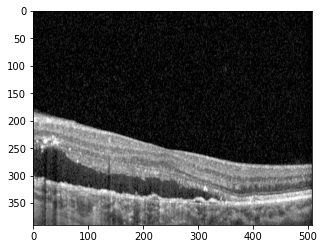

In [14]:
import os

MIN_ROW = 10
MAX_ROW = 400
RANGE_THRESHOLD = 145

os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
image_files = os.listdir()
#os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
#for img_name in image_files:
img_name = image_files[25]
img = cv.imread(img_name)
#img = img[MIN_ROW:MAX_ROW,500:,:]
#new_name = 'cropped_'+img_name
#cv.imwrite(new_name, img)

count, th = 1, 10
fig = plt.figure(figsize=(5, 5))

#while th <= 210:
#  val = th + 55
  
#  th_img, eroded, dilated = apply_threshold(img, th, val)
  #th_img = custom_threshold(img,th, val)
  #show_image(th_img, count, th, fig, plt)
  
#  ax = fig.add_subplot(6, 2, count)
#  plt.imshow(th_img)
#  text_to_add = "Applied Threshold is "+ str(th)
#  ax.title.set_text(text_to_add)
  
#  count += 1
#  th += 20
  #wh_range = return_white_range(th_img)
  #if wh_range > RANGE_THRESHOLD:      ## white pixels are more dispersed
   # print("The given image is abnormal")
  #else:
  #  print("The given image is Normal")
  #break
plt.imshow(img)
plt.show()


In [15]:
def show_img(img2show):
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()

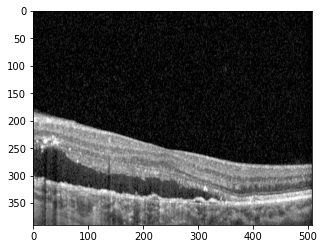

In [16]:
## Apply denoising (Median Filters [23,24,37] )
## 3 × 3 pixels 
filtered_img = cv.medianBlur(img, 3)
show_img(filtered_img)


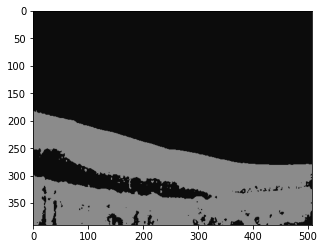

In [20]:
## Apply K-Mean Clustering (Color Quantization)
Z = filtered_img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((filtered_img.shape))
#cv.imshow('res2',res2)
#show_img(res2)
fig = plt.figure(figsize=(5, 5))
plt.imshow(res2)
plt.show()
#cv.waitKey(0)
#cv.destroyAllWindows()


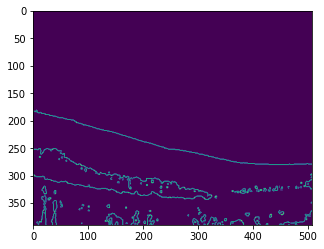

In [22]:
### Apply Canny Edge Detector
edges = cv.Canny(res2,50,200)

fig = plt.figure(figsize=(5, 5))
plt.imshow(edges)
plt.show()

(390, 508)


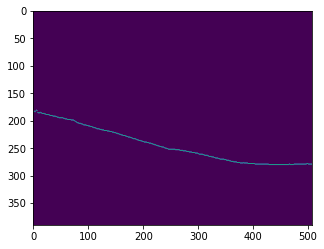

In [41]:
## Detect position of ILM
print(edges.shape) ## 390, 508 ==> Rows x Cols
rows, cols = edges.shape
#center = cols//2
ilm_pos = []
seg_img = np.zeros((rows, cols), np.uint8)
for col in range(cols-1, 0, -1):
  for row in range(rows):
    if edges[row, col] == 255:
      seg_img[row, col] = 255
      pos = (row, col)
      ilm_pos.append(pos)
      #print("In the loop", row, col)
      break

fig = plt.figure(figsize=(5, 5))
plt.imshow(seg_img)
plt.show()

In [42]:
print(ilm_pos)

[(279, 507), (279, 506), (279, 505), (279, 504), (279, 503), (279, 502), (279, 501), (278, 500), (278, 499), (278, 498), (279, 497), (279, 496), (279, 495), (279, 494), (279, 493), (279, 492), (279, 491), (279, 490), (279, 489), (279, 488), (279, 487), (279, 486), (279, 485), (279, 484), (279, 483), (279, 482), (279, 481), (279, 480), (279, 479), (279, 478), (279, 477), (279, 476), (279, 475), (280, 474), (280, 473), (280, 472), (280, 471), (280, 470), (280, 469), (280, 468), (279, 467), (279, 466), (280, 465), (280, 464), (280, 463), (280, 462), (280, 461), (280, 460), (280, 459), (280, 458), (280, 457), (280, 456), (280, 455), (280, 454), (280, 453), (280, 452), (280, 451), (280, 450), (280, 449), (280, 448), (280, 447), (280, 446), (280, 445), (280, 444), (280, 443), (280, 442), (280, 441), (280, 440), (280, 439), (280, 438), (280, 437), (280, 436), (280, 435), (280, 434), (280, 433), (280, 432), (280, 431), (280, 430), (280, 429), (279, 428), (279, 427), (279, 426), (279, 425), (27

(390, 508, 3)


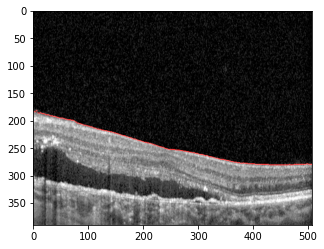

In [45]:
print(img.shape)

for position in ilm_pos:
  (row, col) = position
  img[row:row+2, col, 0] = 255

fig = plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()